# Install packages

In [ ]:
import os
import torch
import requests
from PIL import Image
from transformers import AutoProcessor, OmDetTurboForObjectDetection
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.patches as patches


drive.mount('/content/drive')



Mounted at /content/drive


# Omdet-Turbo model loader

In [ ]:
processor = AutoProcessor.from_pretrained("omlab/omdet-turbo-swin-tiny-hf", use_fast=True)
model = OmDetTurboForObjectDetection.from_pretrained("omlab/omdet-turbo-swin-tiny-hf")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/462M [00:00<?, ?B/s]

# Updating images from a folder

In [ ]:
def load_images_from_folder(dataset_path):
    images = []
    filenames = []
    for filename in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, filename)
        if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                image = Image.open(file_path).convert("RGB")
                images.append(image)
                filenames.append(filename) # Append the filename
            except Exception as e:
                print(f"Errore nell'aprire {file_path}: {e}")
    return images, filenames

# Percorso alla cartella con le immagini
dataset_path = "/content/drive/MyDrive/Colab Notebooks/dataset"

images, filenames = load_images_from_folder(dataset_path)


# Defining classes and prompt

In [ ]:
# Classi da rilevare e descrizione testuale
classes = ["damaged car"]
task = "Detect damaged or crashed vehicles, including cars with visible deformation, broken parts, or collision impact."

# Inferenza batch con Omdet

In [ ]:
results = []
batch_size = 8

for i in range(0, len(images), batch_size):
    batch_imgs = images[i:i+batch_size]
    batch_texts = [classes] * len(batch_imgs)
    batch_tasks = [task] * len(batch_imgs)

    inputs = processor(
        images=batch_imgs,
        text=batch_texts,
        task=batch_tasks,
        return_tensors="pt",
        padding=True
    )

    with torch.no_grad():
        outputs = model(**inputs)

    batch_results = processor.post_process_grounded_object_detection(
        outputs,
        classes=[classes]*len(batch_imgs),
        target_sizes=[img.size[::-1] for img in batch_imgs],
        threshold=0.2,
        nms_threshold=0.3,
    )

    results.extend(batch_results)


Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.


# Visualize Results

/usr/local/lib/python3.11/dist-packages/transformers/models/omdet_turbo/processing_omdet_turbo.py:80: FutureWarning: The `classes` key is deprecated for `OmDetTurboProcessor.post_process_grounded_object_detection` output dict and will be removed in a 4.51.0 version. Please use `text_labels` instead.
  warnings.warn(self.message, FutureWarning)


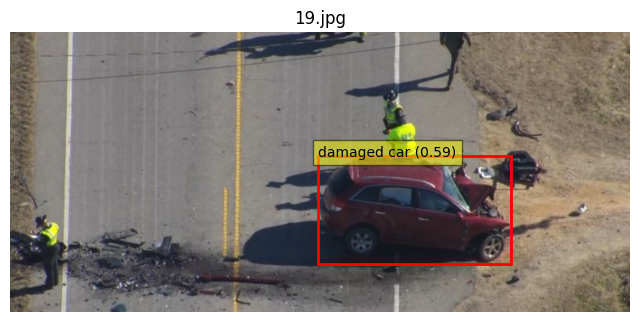

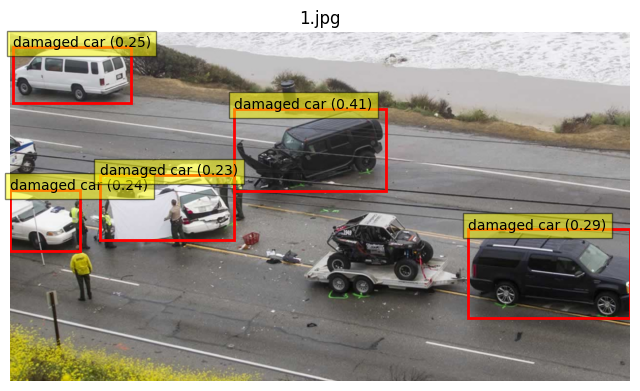

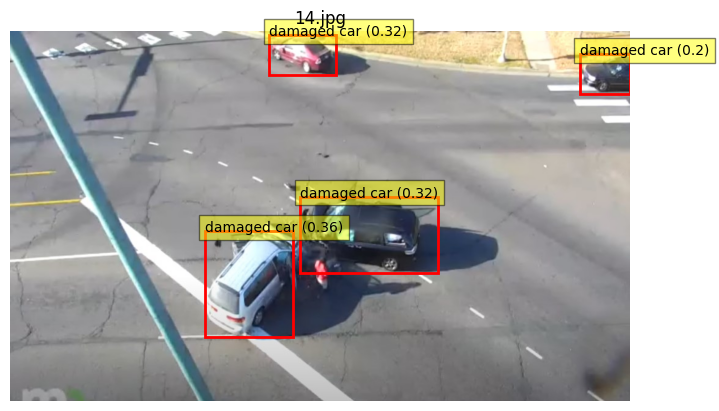

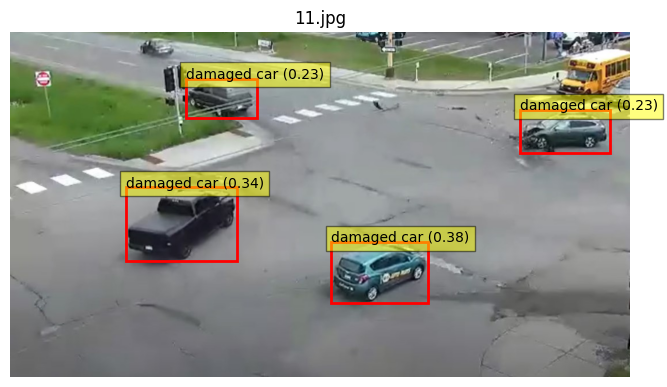

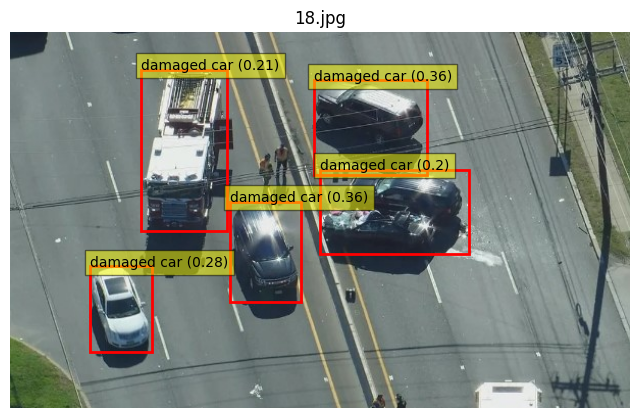

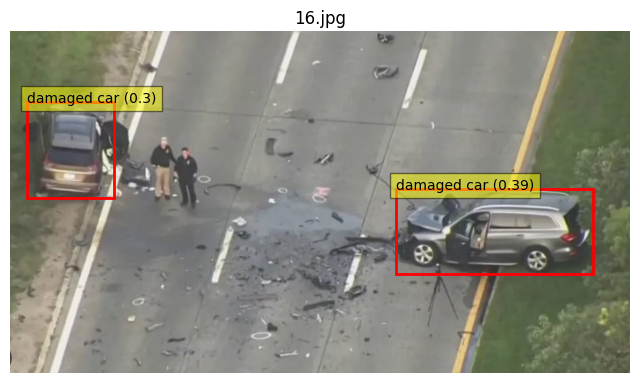

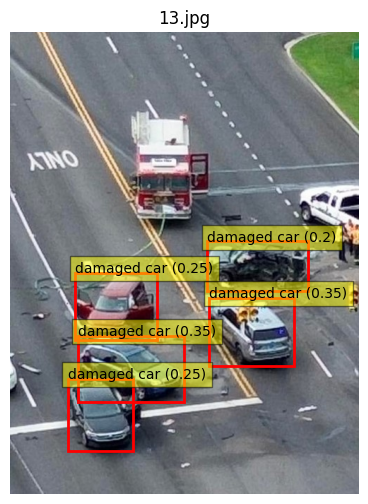

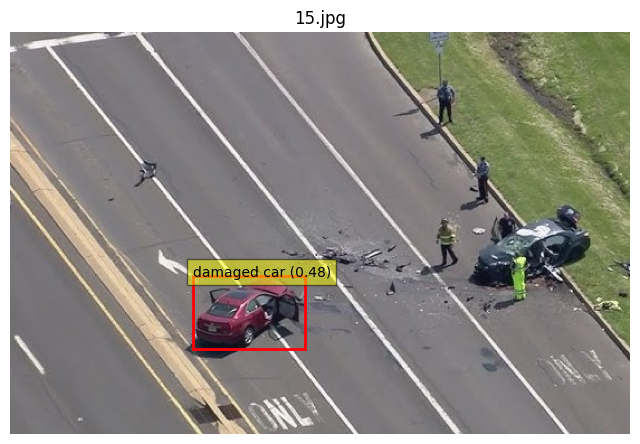

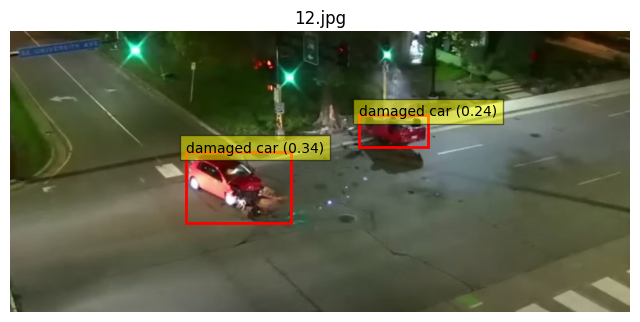

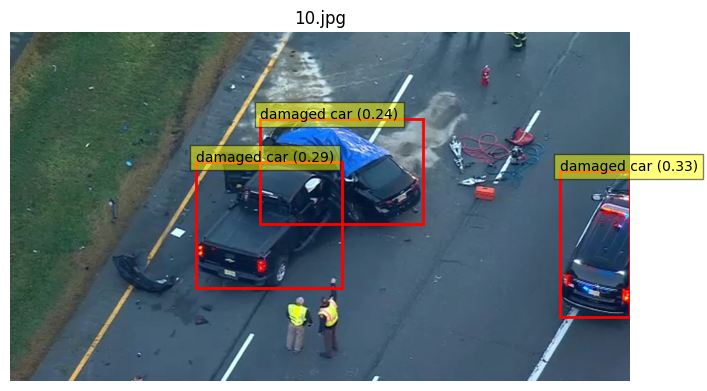

In [ ]:

def show_detections(image, detections, title=""):
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(image)
    for score, label, box in zip(detections["scores"], detections["classes"], detections["boxes"]):
        x0, y0, x1, y1 = box.tolist()
        ax.add_patch(patches.Rectangle((x0, y0), x1 - x0, y1 - y0,
                                       linewidth=2, edgecolor='red', facecolor='none'))
        ax.text(x0, y0, f"{label} ({round(score.item(),2)})",
                bbox=dict(facecolor='yellow', alpha=0.5))
    ax.set_title(title)
    plt.axis('off')
    plt.show()

# Visualizza le prime 10 immagini annotate
for i in range(min(10, len(images))):
    show_detections(images[i], results[i], filenames[i])


#Saving Omdet predictions as Yolo format in a folder

In [ ]:
def save_omdet_predictions_as_yolo(results, images, filenames, classes, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for res, img, fname in zip(results, images, filenames):
        width, height = img.size
        name = os.path.splitext(fname)[0]  # rimuove .jpg ecc.
        txt_path = os.path.join(output_folder, f"{name}.txt")
        lines = []

        for box, label in zip(res["boxes"], res["classes"]):
            x1, y1, x2, y2 = box.tolist()

            cx = (x1 + x2) / 2 / width
            cy = (y1 + y2) / 2 / height
            w = (x2 - x1) / width
            h = (y2 - y1) / height
            class_id = classes.index(label)

            lines.append(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

        with open(txt_path, "w") as f:
            f.writelines(lines)


# Compute IoU

In [ ]:
def compute_iou(box1, box2):
    # Extracts values of two boxes
    cx1, cy1, w1, h1 = box1
    cx2, cy2, w2, h2 = box2

   # Convert from Yolo features to Corner box point: [cx, cy, w, h] → [x_min, y_min, x_max, y_max]
    x1_min = cx1 - w1 / 2
    y1_min = cy1 - h1 / 2
    x1_max = cx1 + w1 / 2
    y1_max = cy1 + h1 / 2

    x2_min = cx2 - w2 / 2
    y2_min = cy2 - h2 / 2
    x2_max = cx2 + w2 / 2
    y2_max = cy2 + h2 / 2

   # Calculate area of ​​intersection
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    # Calculate total areas and union area
    area1 = w1 * h1
    area2 = w2 * h2

    union_area = area1 + area2 - inter_area

    if union_area == 0:
        return 0.0
        ù
    # Calculate IoU
    iou = inter_area / union_area
    return round(iou, 4)

# Calculate average IoU for each file and globally

In [ ]:
def evaluate_model(gt_folder, predicted_folder):
  global_ious = []

  for filename in sorted(os.listdir(gt_folder)):
      if not filename.endswith(".txt"):
          continue

      gt_path = os.path.join(gt_folder, filename)
      pred_path = os.path.join(predicted_folder, filename)

      if not os.path.exists(pred_path):
          print(f"⚠️ Predizione mancante per {filename}")
          continue

      # Leggi GT: class cx cy w h
      with open(gt_path, 'r') as f:
          gt_boxes = [list(map(float, line.strip().split())) for line in f if line.strip()]

      # Leggi predizioni: class cx cy w h
      with open(pred_path, 'r') as f:
          pred_boxes = [list(map(float, line.strip().split())) for line in f if line.strip()]

      file_ious = []

      for gt in gt_boxes:
          gt_box = gt[1:]
          best_iou = 0.0

          for pred in pred_boxes:
              pred_box = pred[1:]
              iou = compute_iou(gt_box, pred_box)
              best_iou = max(best_iou, iou)

          file_ious.append(best_iou)
          global_ious.append(best_iou)

      # IoU avarage for each file
      if file_ious:
          avg_file_iou = sum(file_ious) / len(file_ious)
          print(f"📁 {filename} — media IoU = {avg_file_iou:.4f}")
      else:
          print(f"📁 {filename} — ⚠️ nessun box da valutare.")

  # Global IoU avarage
  if global_ious:
      avg_iou = sum(global_ious) / len(global_ious)
      print(f"\n✅ Media IoU globale dei box: {avg_iou:.4f}")
  else:
      print("\n❌ Nessun confronto valido effettuato.")


In [ ]:
# === Ground truth folder paths and predicted model annotations folder ===
gt_folder = "/content/drive/MyDrive/Colab Notebooks/dataset/annotations"
predicted_folder = "/content/drive/MyDrive/Colab Notebooks/dataset/Omdet-turboAnnotations"
pred_folder = "/content/drive/MyDrive/Colab Notebooks/dataset/Omdet-turboAnnotations"
save_omdet_predictions_as_yolo(results, images, filenames, classes, pred_folder)

evaluate_model(gt_folder, predicted_folder)


📁 1.txt — media IoU = 0.6585
📁 10.txt — media IoU = 0.4490
📁 11.txt — media IoU = 0.4023
📁 12.txt — media IoU = 0.7821
📁 13.txt — media IoU = 0.7435
📁 14.txt — media IoU = 0.8125
📁 15.txt — media IoU = 0.4482
📁 16.txt — media IoU = 0.8656
📁 17.txt — media IoU = 0.4305
📁 18.txt — media IoU = 0.4754
📁 19.txt — media IoU = 0.9379
📁 2.txt — media IoU = 0.0000
📁 20.txt — media IoU = 0.4202
📁 21.txt — media IoU = 0.8236
📁 22.txt — media IoU = 0.6710
📁 23.txt — media IoU = 0.8089
📁 24.txt — media IoU = 0.8626
📁 25.txt — media IoU = 0.5829
📁 26.txt — media IoU = 0.8743
📁 27.txt — media IoU = 0.6401
📁 28.txt — media IoU = 0.8993
📁 29.txt — media IoU = 0.9079
📁 3.txt — media IoU = 0.7873
📁 4.txt — media IoU = 0.6199
📁 5.txt — media IoU = 0.8212
📁 6.txt — media IoU = 0.8034
📁 7.txt — media IoU = 0.8539
📁 8.txt — media IoU = 0.8242
📁 9.txt — media IoU = 0.6256

✅ Media IoU globale dei box: 0.6996
